# Time Series Analysis
Time Series Analysis in Python: 
* https://www.machinelearningplus.com/time-series/time-series-analysis-python/
* https://github.com/oreilly-mlsec/book-resources/blob/master/chapter3/arima-forecasting.ipynb
* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
* https://habr.com/ru/company/ods/blog/327242/

## Read data

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
df = pd.read_csv("dataset.txt", sep="\t", skiprows=0, names=['Year', 'Month', 'Value'])
df.head(5)

,Year,Month,Value
0,2009,1,22503.00
1,2009,1,26366.70
2,2009,2,28789.15
3,2009,2,7501.00
4,2009,3,28515.55


In [22]:
# Merge year and month columns into one date column
df['Date'] = pd.to_datetime(df['Year'].map(str) + '-' + df['Month'].map(str) + '-01')
df.head()

,Year,Month,Value,Date
0,2009,1,22503.00,2009-01-01
1,2009,1,26366.70,2009-01-01
2,2009,2,28789.15,2009-02-01
3,2009,2,7501.00,2009-02-01
4,2009,3,28515.55,2009-03-01


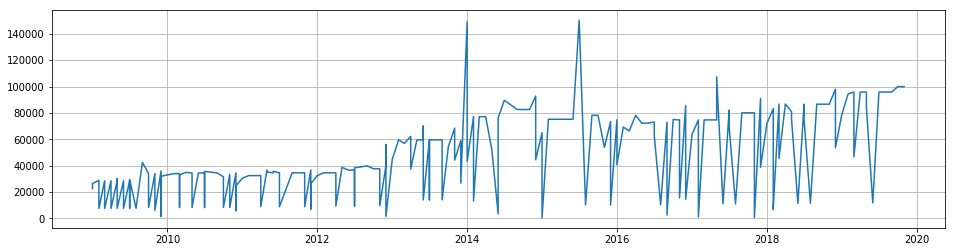

In [23]:
plt.figure(figsize=(16,4))
plt.plot(df['Date'], df['Value'])
plt.grid()

In [24]:
# Combine monthly values
aggregation_functions = {'Value': 'sum', 'Year': 'first'}
df1 = df.groupby(df['Date'], as_index=False).aggregate(aggregation_functions)
df1.head()

,Date,Value,Year
0,2009-01-01,48869.70,2009
1,2009-02-01,36290.15,2009
2,2009-03-01,36016.55,2009
3,2009-04-01,36016.55,2009
4,2009-05-01,66020.55,2009


In [25]:
means = df1.groupby(df1['Year'], as_index=False).mean()
df1['ValueMean'] = df1['Year']
df1['ValueMean'] = df1.apply(lambda x: means.loc[means['Year'] == x['Year']].values[0,1], axis=1)
df1.head()

,Date,Value,Year,ValueMean
0,2009-01-01,48869.70,2009,47298.504167
1,2009-02-01,36290.15,2009,47298.504167
2,2009-03-01,36016.55,2009,47298.504167
3,2009-04-01,36016.55,2009,47298.504167
4,2009-05-01,66020.55,2009,47298.504167


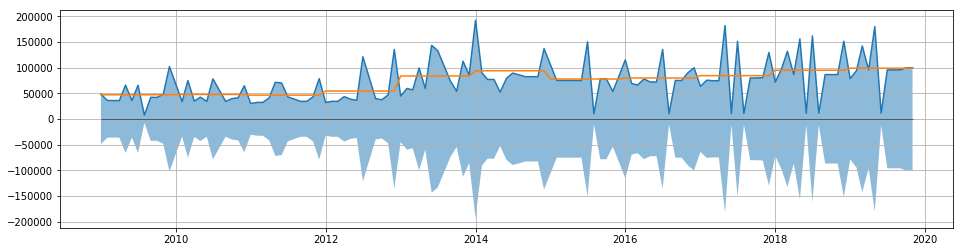

In [26]:
plt.figure(figsize=(16,4))
plt.plot(df1['Date'], df1['Value'])
plt.plot(df1['Date'], df1['ValueMean'])
plt.fill_between(df1['Date'], y1=df1['Value'], y2=-df1['Value'], alpha=0.5, linewidth=2)
plt.hlines(y=0, xmin=df1['Date'].min(), xmax=df1['Date'].max(), linewidth=.5)
plt.grid()

## Additive and multiplicative time series
**Additive time series:**
Value = Base Level + Trend + Seasonality + Error

**Multiplicative Time Series:**
Value = Base Level x Trend x Seasonality x Error

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

timeseries = pd.DataFrame()
timeseries['Date'] = df1['Date'].values
# timeseries['Value'] = df1['ValueMean'].values
timeseries['Value'] = df1['Value'].values
timeseries.set_index('Date', inplace=True)
timeseries['Value'] = timeseries['Value'].astype(float)

In [28]:
timeseries.head()

,Value
Date,
2009-01-01,48869.70
2009-02-01,36290.15
2009-03-01,36016.55
2009-04-01,36016.55
2009-05-01,66020.55


In [29]:
timeseries.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01'],
              dtype='datetime64[ns]', name='Date', length=126, freq=None)

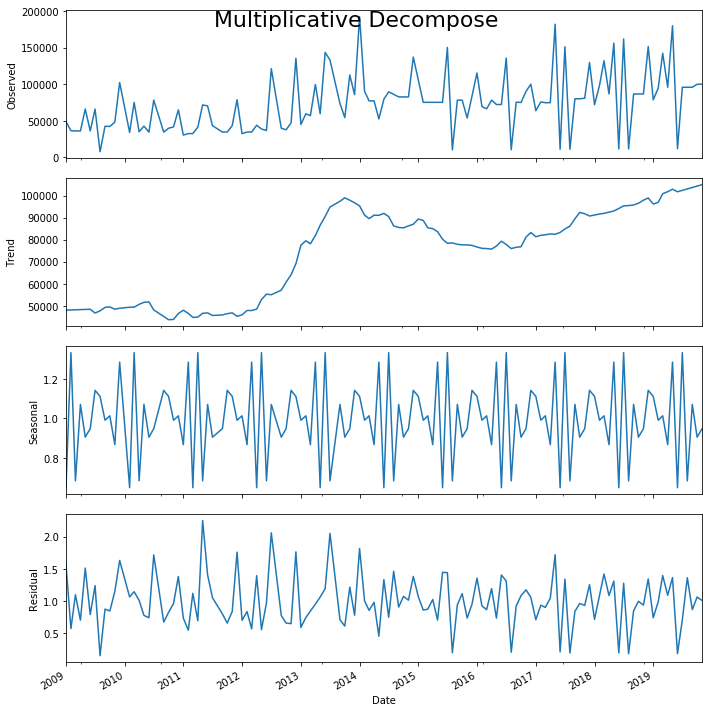

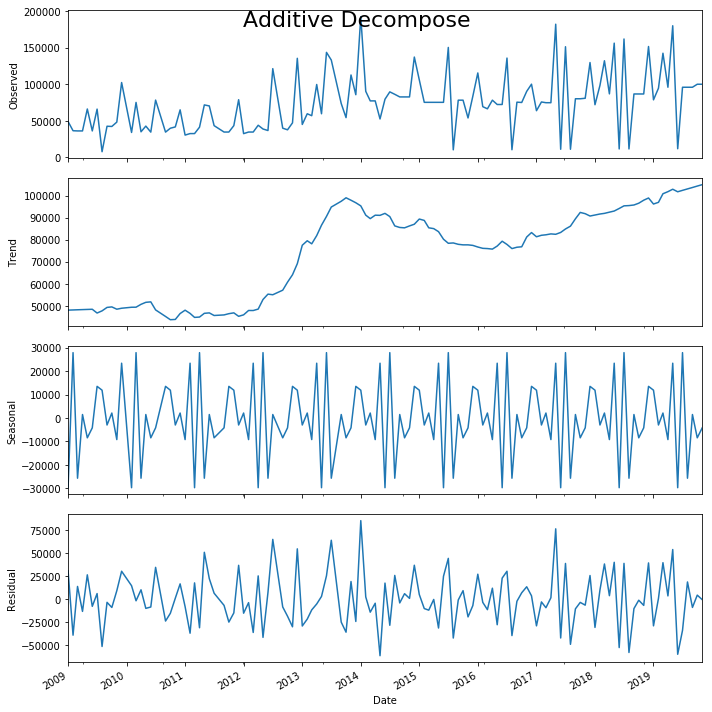

In [30]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(timeseries['Value'], model='multiplicative', freq=12, extrapolate_trend=12)

# Additive Decomposition
result_add = seasonal_decompose(timeseries['Value'], model='additive', freq=12, extrapolate_trend=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

## Time series forecasting with ARIMA

In [31]:
import itertools
import statsmodels.api as sm

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [32]:
import warnings
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(timeseries['Value'], 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3191.7080099387053
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2843.8397297813353
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2696.2851110868783
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2406.933189129684
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2720.3078473589967
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2688.365576243554
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2430.3296780866176
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2408.8783973240147
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3131.1968422014634
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2799.85910689448
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2673.2240202204484
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2385.8211899582757
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2823.747988073156
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2774.4542566184523
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2432.49890109806
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2387.7752587345726
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3067.2936266877705
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2759.332571455766


In [33]:
mod = sm.tsa.statespace.SARIMAX(timeseries['Value'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2296      0.135     -1.698      0.090      -0.495       0.035
ma.L1         -0.8454      0.083    -10.192      0.000      -1.008      -0.683
ar.S.L12       0.3123      0.221      1.416      0.157      -0.120       0.745
ma.S.L12      -0.7517      0.173     -4.341      0.000      -1.091      -0.412
sigma2      1.459e+09   1.06e-10   1.38e+19      0.000    1.46e+09    1.46e+09


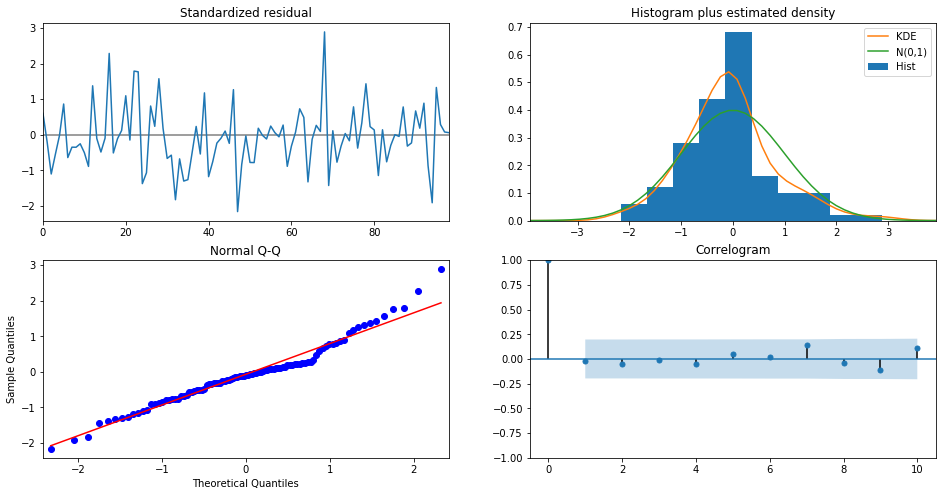

In [34]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

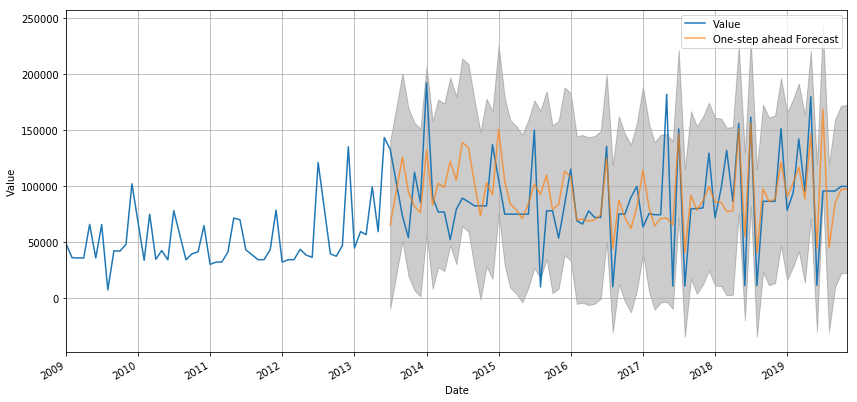

In [35]:
pred = results.get_prediction(start=50, dynamic=False)
pred_ci = pred.conf_int()
ax = timeseries['2009':].plot(label='Value')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [36]:
forecasted = pd.DataFrame(pred.predicted_mean, columns=timeseries.columns)
truth = timeseries['2010-01-01':]
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of forecasts is Value    1.107026e+09
dtype: float64


In [37]:
import numpy as np
print('The Root Mean Squared Error of forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of forecasts is Value    33272.0
dtype: float64


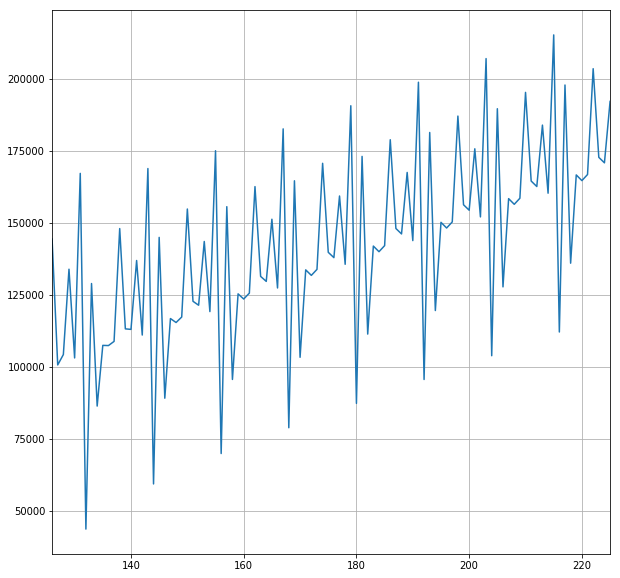

In [38]:
pred_uc = results.get_forecast(steps=100)
pred_uc.predicted_mean.plot()
plt.grid()